<a href="https://colab.research.google.com/github/kenanmorani/image_processing_idu/blob/main/3d_image_segmentation_Train_and_test_batch64_2epochs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
import nibabel as nib

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow import keras

In [36]:
# Mounting my google drive
from google.colab import drive

In [37]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Slicing and Saving, CONDUCTED LOCALLY

In [ ]:
dataInputPath = '/home/kenan/Desktop/data/volumes/'
imagePathInput = os.path.join(dataInputPath, 'img/')
maskPathInput = os.path.join(dataInputPath, 'mask/')

#  Before running the code, 16 images and 16 masks out of 20 exist in folder '/home/kenan/Desktop/data/volumes/' = The training set
dataOutputPath = '/home/kenan/Desktop/data/slices/training/'
imageSliceOutput = os.path.join(dataOutputPath, 'img/')
maskSliceOutput = os.path.join(dataOutputPath, 'mask/')

SLICE_X = True
SLICE_Y = True
SLICE_Z = True

SLICE_DECIMATE_IDENTIFIER = 3

# Loading image to check max min Hounsfield units
imgPath = os.path.join(imagePathInput, '1.nii.gz')
img = nib.load(imgPath).get_fdata()
np.min(img), np.max(img), img.shape, type(img)

# Loading image mask to check max min Hounsfield units
maskPath = os.path.join(maskPathInput, '1.nii.gz')
mask = nib.load(maskPath).get_fdata()
np.min(mask), np.max(mask), mask.shape, type(mask)

# Showing image slice
imgSlice = mask[:,:,100]
plt.imshow(imgSlice, cmap='gray')
plt.show()

# Choosing normalization boundaries suitable from the chosen images
HOUNSFIELD_MIN = -1020
HOUNSFIELD_MAX = 2995
HOUNSFIELD_RANGE = HOUNSFIELD_MAX - HOUNSFIELD_MIN

# Normalizing the images
def normalizeImageIntensityRange (img):
    img[img < HOUNSFIELD_MIN] = HOUNSFIELD_MIN
    img[img > HOUNSFIELD_MAX] = HOUNSFIELD_MAX
    return (img - HOUNSFIELD_MIN) / HOUNSFIELD_RANGE

nImg = normalizeImageIntensityRange(img)
np.min(nImg), np.max(nImg), nImg.shape, type(nImg)

# Reading image or mask volume
def readImageVolume(imgPath, normalize=True):
    img = nib.load(imgPath).get_fdata()
    if normalize:
        return normalizeImageIntensityRange(img)
    else:
        return img
    
readImageVolume(imgPath, normalize=True)
readImageVolume(maskPath, normalize=True)

# Saving volume slices to file
def saveSlice (img, fname, path):
    img = np.uint8(img * 255)
    fout = os.path.join(path, f'{fname}.png')
    cv2.imwrite(fout, img)
    print(f'[+] Slice saved: {fout}', end='\r')

# Slicing image in all directions and save
def sliceAndSaveVolumeImage(vol, fname, path):
    (dimx, dimy, dimz) = vol.shape
    print(dimx, dimy, dimz)
    cnt = 0
    if SLICE_X:
        cnt += dimx
        print('Slicing X: ')
        for i in range(dimx):
            saveSlice(vol[i,:,:], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_x', path)
            
    if SLICE_Y:
        cnt += dimy
        print('Slicing Y: ')
        for i in range(dimy):
            saveSlice(vol[:,i,:], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_y', path)
            
    if SLICE_Z:
        cnt += dimz
        print('Slicing Z: ')
        for i in range(dimz):
            saveSlice(vol[:,:,i], fname+f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_z', path)
    return cnt

# Reading and processing image volumes
for index, filename in enumerate(sorted(glob.iglob(imagePathInput+'*.nii.gz'))):
    img = readImageVolume(filename, True)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    numOfSlices = sliceAndSaveVolumeImage(img, 't'+str(index), imageSliceOutput)
    print(f'\n{filename}, {numOfSlices} slices created \n')

# Reading and processing image mask volumes
for index, filename in enumerate(sorted(glob.iglob(maskPathInput+'*.nii.gz'))):
    img = readImageVolume(filename, False)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    numOfSlices = sliceAndSaveVolumeImage(img, 't'+str(index), maskSliceOutput)
    print(f'\n{filename}, {numOfSlices} slices created \n')


# Slicing the Test Images, 3 images out of 20
dataInputPath = '/home/kenan/Desktop/data/volumes/TEST'
imagePathInput = os.path.join(dataInputPath, 'img/')
maskPathInput = os.path.join(dataInputPath, 'mask/')

dataOutputPath = '/home/kenan/Desktop/data/slices/test/'
imageSliceOutput = os.path.join(dataOutputPath, 'img/')
maskSliceOutput = os.path.join(dataOutputPath, 'mask/')

# Reading and processing image volumes for TEST images
for index, filename in enumerate(sorted(glob.iglob(imagePathInput+'*.nii.gz'))):
    img = readImageVolume(filename, True)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    numOfSlices = sliceAndSaveVolumeImage(img, 't'+str(index), imageSliceOutput)
    print(f'\n{filename}, {numOfSlices} slices created \n')

# Reading and processing image mask volumes for TEST masks
for index, filename in enumerate(sorted(glob.iglob(maskPathInput+'*.nii.gz'))):
    img = readImageVolume(filename, False)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    numOfSlices = sliceAndSaveVolumeImage(img, 't'+str(index), maskSliceOutput)
    print(f'\n{filename}, {numOfSlices} slices created \n')


# Building, Training and Tssting a 2D-UNET model

In [38]:
# Defining constants
SEED = 909
BATCH_SIZE_TRAIN = 64
BATCH_SIZE_TEST = 64

In [39]:
IMAGE_HEIGHT = 240
IMAGE_WIDTH = 240
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

In [40]:
# NEW PATHS That images should be at before running the follwoing steps are as shown in green
data_dir = '/content/gdrive/MyDrive/Image Processing/COVID-19 CT/slices/'
data_dir_train = os.path.join(data_dir, 'training')
# The images should be stored under: "/content/gdrive/MyDrive/Image Processing/data2/slices/training/img/img"
data_dir_train_image = os.path.join(data_dir_train, 'img')
# The images should be stored under: "/content/gdrive/MyDrive/Image Processing/data2/slices/training/mask/img"
data_dir_train_mask = os.path.join(data_dir_train, 'mask')

data_dir_test = os.path.join(data_dir, 'test')
# The images should be stored under: ".../data/slices/test/img/img"
data_dir_test_image = os.path.join(data_dir_test, 'img')
# The images should be stored under: ".../data/slices/test/mask/img"
data_dir_test_mask = os.path.join(data_dir_test, 'mask')

In [41]:
# NUmber of images for training and testing 
NUM_TRAIN = 20869
NUM_TEST = 5262

In [8]:
# Number of epochs
NUM_OF_EPOCHS = 30

In [42]:
def create_segmentation_generator_train(img_path, msk_path, BATCH_SIZE):
# Dataaugmentation, featurewise_center, featurewise_std_normalization and rotation_range, are applied on the trained data 
    data_gen_args = dict(rescale=1./255, 
                    #    featurewise_center=True,
                    #   featurewise_std_normalization=True,
                    #  rotation_range=90
                    )
    datagen = ImageDataGenerator(**data_gen_args)
    img_generator = datagen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    msk_generator = datagen.flow_from_directory(msk_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    return zip(img_generator, msk_generator)

def create_segmentation_generator_test(img_path, msk_path, BATCH_SIZE):
    data_gen_args = dict(rescale=1./255)
    datagen = ImageDataGenerator(**data_gen_args) 
    img_generator = datagen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    msk_generator = datagen.flow_from_directory(msk_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    return zip(img_generator, msk_generator)

In [43]:
train_generator = create_segmentation_generator_train(data_dir_train_image, data_dir_train_mask, BATCH_SIZE_TRAIN)

Found 20869 images belonging to 1 classes.
Found 20869 images belonging to 1 classes.


In [44]:
test_generator = create_segmentation_generator_test(data_dir_test_image, data_dir_test_mask, BATCH_SIZE_TEST)

Found 5262 images belonging to 1 classes.
Found 5262 images belonging to 1 classes.


In [45]:
# Displaying images
def display(display_list):
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='gray')
    plt.show()

def show_dataset(datagen, num=1):
    for i in range(0, num):
        image,mask = next(datagen)
        display((image[0], mask[0]))

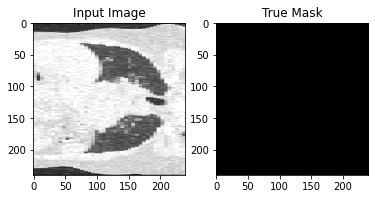

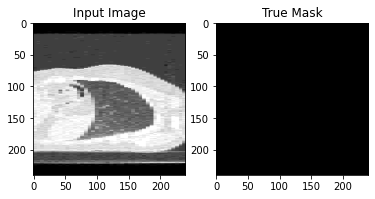

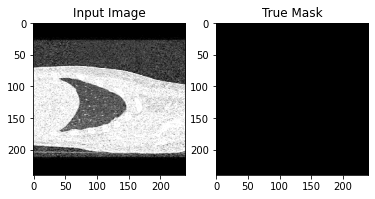

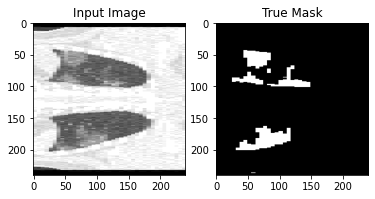

In [ ]:
show_dataset(test_generator, 2)
show_dataset(train_generator, 2)

In [46]:
# Building 2D-UNET model
def unet(n_levels, initial_features=32, n_blocks=2, kernel_size=3, pooling_size=2, in_channels=1, out_channels=1):
    inputs = keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, in_channels))
    x = inputs
    
    convpars = dict(kernel_size=kernel_size, activation='relu', padding='same')
    
    #downstream
    skips = {}
    for level in range(n_levels):
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
        if level < n_levels - 1:
            skips[level] = x
            x = keras.layers.MaxPool2D(pooling_size)(x)
            
    # upstream
    for level in reversed(range(n_levels-1)):
        x = keras.layers.Conv2DTranspose(initial_features * 2 ** level, strides=pooling_size, **convpars)(x)
        x = keras.layers.Concatenate()([x, skips[level]])
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
            
    # output
    activation = 'sigmoid' if out_channels == 1 else 'softmax'
    x = keras.layers.Conv2D(out_channels, kernel_size=1, activation=activation, padding='same')(x)
    
    return keras.Model(inputs=[inputs], outputs=[x], name=f'UNET-L{n_levels}-F{initial_features}')

In [47]:
EPOCH_STEP_TRAIN =  (NUM_TRAIN // BATCH_SIZE_TRAIN) // 2
EPOCH_STEP_TEST =   (NUM_TEST // BATCH_SIZE_TEST) // 2

In [48]:
model = unet(4)

In [49]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [50]:
model.summary()

Model: "UNET-L4-F32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 240, 240, 1) 0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 240, 240, 32) 320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 240, 240, 32) 9248        conv2d_30[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 120, 120, 32) 0           conv2d_31[0][0]                  
________________________________________________________________________________________

In [51]:
from keras.models import load_model

In [52]:
checkpoint_path = "/content/gdrive/MyDrive/Image Processing/COVID-19 CT/train_ckpt/cp.ckpt"

In [54]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_freq=1)

In [56]:
model.fit_generator(generator=train_generator, 
                    steps_per_epoch=EPOCH_STEP_TRAIN, 
                    validation_data=test_generator, 
                    validation_steps=EPOCH_STEP_TEST,
                    epochs=NUM_OF_EPOCHS,
                    callbacks=[cp_callback])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2
  1/163 [..............................] - ETA: 3:54:18 - loss: 0.6909 - accuracy: 0.9022
Epoch 00001: saving model to /content/gdrive/MyDrive/Image Processing/COVID-19 CT/train_ckpt/cp.ckpt
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Image Processing/COVID-19 CT/train_ckpt/cp.ckpt/assets
  2/163 [..............................] - ETA: 3:57:44 - loss: 0.6877 - accuracy: 0.9250
Epoch 00001: saving model to /content/gdrive/MyDrive/Image Processing/COVID-19 CT/train_ckpt/cp.ckpt
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Image Processing/COVID-19 CT/train_ckpt/cp.ckpt/assets
  3/163 [..............................] - ETA: 3:55:29 - loss: 0.6839 - accuracy: 0.9374
Epoch 00001: saving model to /content/gdrive/MyDrive/Image Processing/COVID-19 CT/train_ckpt/cp.ckpt
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Image Processing/COVID-19 CT/train_ckpt/cp.ckpt/assets
  4/163 [..............................] - ETA: 3:53:15 - loss: 0.6793 - ac

In [ ]:
loss,acc = model.evaluate(test_images,  test_labels, verbose=2)

# Load the saved model and predict

In [57]:
!mkdir -p saved_model
model.save('/content/gdrive/MyDrive/Image Processing/COVID-19 CT/saved_model/my_model_2epoch')
model.save('/content/gdrive/MyDrive/Image Processing/COVID-19 CT/saved_model/mymodel_2epoch.h5')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Image Processing/COVID-19 CT/saved_model/my_model_2epoch/assets


In [ ]:
model_ckpt2 = unet(4)

In [ ]:
model_ckpt2.load_weights(checkpoint_path)

In [ ]:
loss,acc = model_ckpt2.evaluate(test_images,  test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

In [ ]:
model_ckpt2.fit_generator(generator=train_generator, 
                    steps_per_epoch=EPOCH_STEP_TRAIN, 
                    validation_data=test_generator,
                    validation_steps=EPOCH_STEP_TEST,
                    epochs=NUM_OF_EPOCHS,
                    callbacks=[cp_callback])

In [ ]:
model = load_model('/content/gdrive/MyDrive/Image Processing/data2/saved_model/mymodel.h5')

In [58]:
test_generator = create_segmentation_generator_test(data_dir_test_image, data_dir_test_mask, 1)

Found 5262 images belonging to 1 classes.
Found 5262 images belonging to 1 classes.


In [59]:
from keras.metrics import MeanIoU

In [60]:
def show_prediction(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        pred_mask = model.predict(image)[0] > 0.5
        display([image[0], mask[0], pred_mask])
        num_classes = 2
        IOU_keras = MeanIoU(num_classes=num_classes)  
        IOU_keras.update_state(mask[0], pred_mask)
        print("Mean IoU =", IOU_keras.result().numpy())

        values = np.array(IOU_keras.get_weights()).reshape(num_classes, num_classes)
        print(values)

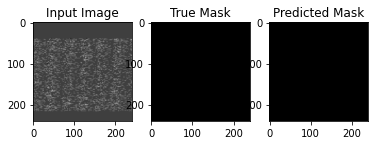

Mean IoU = 1.0
[[57600.     0.]
 [    0.     0.]]


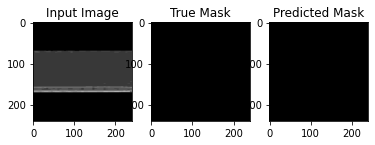

Mean IoU = 1.0
[[57600.     0.]
 [    0.     0.]]


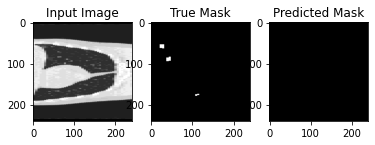

Mean IoU = 0.49789062
[[57357.     0.]
 [  243.     0.]]


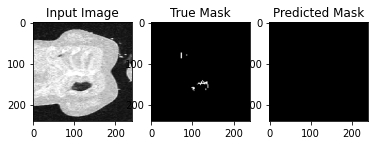

Mean IoU = 0.49801216
[[57371.     0.]
 [  229.     0.]]


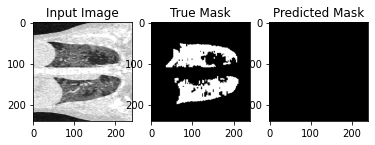

Mean IoU = 0.39979166
[[46056.     0.]
 [11544.     0.]]


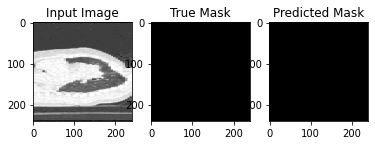

Mean IoU = 1.0
[[57600.     0.]
 [    0.     0.]]


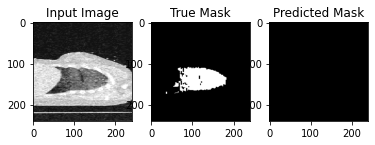

Mean IoU = 0.45540798
[[52463.     0.]
 [ 5137.     0.]]


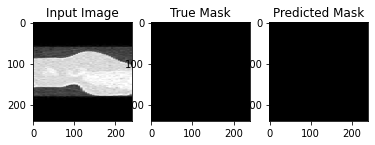

Mean IoU = 1.0
[[57600.     0.]
 [    0.     0.]]


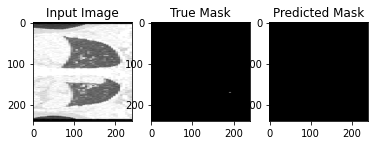

Mean IoU = 0.4999566
[[5.7595e+04 0.0000e+00]
 [5.0000e+00 0.0000e+00]]


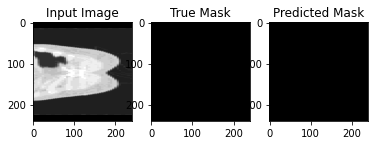

Mean IoU = 1.0
[[57600.     0.]
 [    0.     0.]]


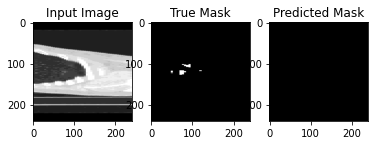

Mean IoU = 0.4976736
[[57332.     0.]
 [  268.     0.]]


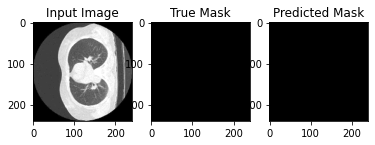

Mean IoU = 1.0
[[57600.     0.]
 [    0.     0.]]


In [62]:
show_prediction(test_generator, 12)